In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl


In [17]:
df = pl.read_parquet(r'D:\20240826_week8\metashape\20241029_products_uav_data\output\extract\polygon_df\plot_10.parquet')
df =df.drop(['distance_xy','angle_rad','vaa_rad','vaa_temp'])
df

Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f32,f64,f32,f32,f32,f32,str
563627.585225,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.086563,"""plot_10""",19.449127,-0.397725,1.470757,4.48,194.578639,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.592477,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085861,"""plot_10""",19.449829,-0.404977,1.470666,4.48,194.314824,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.599728,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085129,"""plot_10""",19.450562,-0.412228,1.470575,4.49,194.051643,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.606979,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.079712,"""plot_10""",19.455978,-0.419479,1.470484,4.49,193.789106,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
563627.614231,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.074341,"""plot_10""",19.461349,-0.426731,1.470393,4.5,193.527221,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563633.869829,5.7130e6,0.006584,0.058976,0.009119,0.140287,0.470458,188.130493,"""plot_10""",19.371399,-44.057329,14.443891,67.32,79.677623,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""
563633.848166,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.124802,"""plot_10""",19.37709,-44.035666,14.451416,67.309998,79.694805,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""
563633.855418,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.125702,"""plot_10""",19.37619,-44.042918,14.451325,67.309998,79.691903,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif"""


(array([5.191120e+05, 1.320846e+06, 1.132418e+06, 9.117050e+05,
        7.873710e+05, 7.159360e+05, 6.661860e+05, 6.319210e+05,
        6.059220e+05, 5.846050e+05, 5.633860e+05, 5.353750e+05,
        5.033640e+05, 4.639720e+05, 4.201200e+05, 3.746670e+05,
        3.302640e+05, 2.877090e+05, 2.471830e+05, 2.105270e+05,
        1.765900e+05, 1.463810e+05, 1.200570e+05, 9.696500e+04,
        7.812900e+04, 6.186900e+04, 4.941000e+04, 3.909600e+04,
        3.025200e+04, 2.375100e+04, 1.819700e+04, 1.393800e+04,
        1.097800e+04, 8.239000e+03, 6.305000e+03, 4.814000e+03,
        3.719000e+03, 2.833000e+03, 2.165000e+03, 1.704000e+03,
        1.357000e+03, 1.059000e+03, 8.500000e+02, 6.660000e+02,
        5.440000e+02, 4.370000e+02, 3.500000e+02, 2.860000e+02,
        2.140000e+02, 1.770000e+02, 1.590000e+02, 1.320000e+02,
        1.020000e+02, 6.900000e+01, 5.600000e+01, 4.900000e+01,
        4.900000e+01, 3.500000e+01, 2.100000e+01, 3.000000e+01,
        2.200000e+01, 1.400000e+01, 1.10

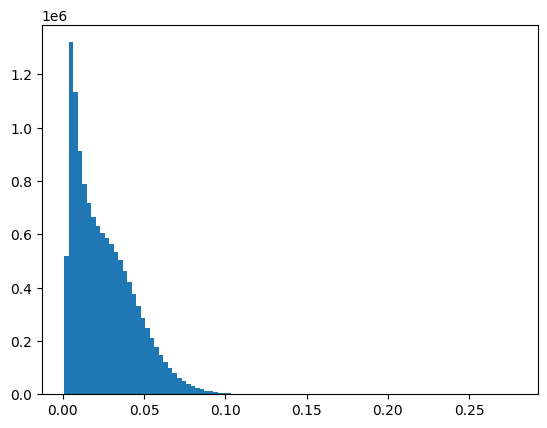

In [18]:
import random
np.random.seed(42)
subset = df.sample(n=100000, with_replacement=True, shuffle=True, seed=42)
plt.hist(df['band1'],bins=100)

In [19]:
df = df.with_columns([
    (pl.col("xcam") - pl.col("Xw")).alias("vx"),
    (pl.col("ycam") - pl.col("Yw")).alias("vy"),
    pl.col("delta_z").alias("vz"),            # already positive
])

df = df.with_columns(
    ((pl.col("vx")**2 + pl.col("vy")**2 + pl.col("vz")**2).sqrt()).alias("v_norm")
)

df = df.with_columns([
    pl.map_batches(["vz", "v_norm"], lambda zs:
           np.degrees(np.arccos(zs[0] / zs[1]))).alias("vza_deg_new"),

    pl.map_batches(["vx", "vy"], lambda xy:
           (np.degrees(np.arctan2(xy[0], xy[1])) % 360)
    ).alias("vaa_deg_new"),
])

df = df.with_columns([
    # Solar Zenith Angle (degrees)
    (90 - pl.col("sunelev")).alias("sza_deg"),

    # View Zenith Angle (degrees)
    pl.col("vza").alias("vza_deg_new"),

    # Relative Azimuth Angle (degrees), wrapped to 0–180°
    (
        ((pl.col("saa") - pl.col("vaa_deg_new")).abs() % 360)              # raw |Δazimuth| ∈ [0, 360)
        .map_elements(                                             # clamp >180° to its supplement
            lambda x: x if x <= 180 else 360 - x,
            return_dtype=pl.Float32
        )
    ).alias("raa_deg"),
])

df



Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path,vx,vy,vz,v_norm,vza_deg_new,vaa_deg_new,sza_deg,raa_deg
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f32,f64,f32,f32,f32,f32,str,f64,f64,f32,f64,f32,f64,f32,f32
563627.585225,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.086563,"""plot_10""",19.449127,-0.397725,1.470757,4.48,194.578639,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.397725,1.470757,19.449127,19.508713,4.48,344.867885,34.929276,165.421356
563627.592477,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085861,"""plot_10""",19.449829,-0.404977,1.470666,4.48,194.314824,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.404977,1.470666,19.449829,19.509554,4.48,344.604069,34.929276,165.685181
563627.599728,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.085129,"""plot_10""",19.450562,-0.412228,1.470575,4.49,194.051643,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.412228,1.470575,19.450562,19.51043,4.49,344.340889,34.929276,165.948364
563627.606979,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.079712,"""plot_10""",19.455978,-0.419479,1.470484,4.49,193.789106,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.419479,1.470484,19.455978,19.515978,4.49,344.078351,34.929276,166.210892
563627.614231,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.074341,"""plot_10""",19.461349,-0.426731,1.470393,4.5,193.527221,563627.1875,5713040.5,55.070724,150.289246,"""IMG_0100_6.tif""",-0.426731,1.470393,19.461349,19.521482,4.5,343.816466,34.929276,166.472778
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563633.869829,5.7130e6,0.006584,0.058976,0.009119,0.140287,0.470458,188.130493,"""plot_10""",19.371399,-44.057329,14.443891,67.32,79.677623,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.057329,14.443891,19.371399,50.248635,67.32,288.151374,46.572296,79.67762
563633.848166,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.124802,"""plot_10""",19.37709,-44.035666,14.451416,67.309998,79.694805,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.035666,14.451416,19.37709,50.234002,67.309998,288.168556,46.572296,79.694801
563633.855418,5.7130e6,NaN,NaN,NaN,NaN,NaN,188.125702,"""plot_10""",19.37619,-44.042918,14.451325,67.309998,79.691903,563589.8125,5.713052e6,43.427704,208.473755,"""IMG_0009_6.tif""",-44.042918,14.451325,19.37619,50.239985,67.309998,288.165654,46.572296,79.691902


In [20]:
def rpv(angle_pack, rho0, k, theta):
    s, v, f = angle_pack
    # deg → rad
    s = np.radians(s);  v = np.radians(v);  f = np.radians(f)
    cos_s, cos_v = np.cos(s), np.cos(v)
    F = 1 + theta * np.cos(f)              # simple phase kernel
    return rho0 * (cos_s**k) * (cos_v**k) * F

0.3557062
ρ₀=0.3692,  k=0.142,  θ=0.128
RMSE=0.1509,  nRMSE=41.0%


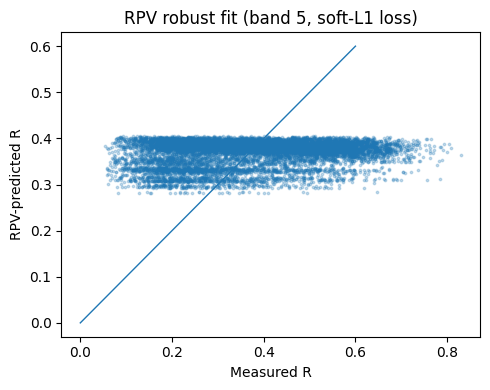

In [21]:
import numpy as np, polars as pl, matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

band = "band5"

# ── 1. Pull filtered pixels to NumPy ───────────────────────────────
df_fit = (
    df.filter((pl.col(band).is_finite()) &
              (pl.col(band) > 0) & (pl.col(band) < 1)).sample(n=10000, with_replacement=True, shuffle=True, seed=42)
)

sza  = df_fit["sza_deg"].to_numpy()
vza  = df_fit["vza_deg_new"].to_numpy()
raa  = df_fit["raa_deg"].to_numpy()
R    = df_fit[band].to_numpy()

print(np.median(R))

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
sza, vza, raa, R = [x[mask] for x in (sza, vza, raa, R)]

# ── 2. Define residual for least_squares ───────────────────────────
def rpv_res(pars, sza, vza, raa, R):
    return rpv((sza, vza, raa), *pars) - R

# initial guess & bounds
p0      = [np.median(R), 1.2, 0.3]
bounds  = ([0, 0, 0], [2, 5, 2])

# ── 3. Robust fit ---------------------------------------------------
res = least_squares(
        rpv_res, p0, bounds=bounds,
        args=(sza, vza, raa, R),
        loss="soft_l1",
        max_nfev=30000, verbose=0
)

rho0, k, theta = res.x
print(f"ρ₀={rho0:.4f},  k={k:.3f},  θ={theta:.3f}")

# ── 4. Evaluate metrics --------------------------------------------
R_hat = rpv((sza, vza, raa), rho0, k, theta)
rmse  = np.sqrt(mean_squared_error(R, R_hat))
nrmse = rmse / R.mean()
print(f"RMSE={rmse:.4f},  nRMSE={nrmse*100:.1f}%")

# ── 5. Scatter plot -------------------------------------------------
plt.figure(figsize=(5,4))
plt.scatter(R, R_hat, s=3, alpha=0.25)
plt.plot([0, 0.6], [0, 0.6], lw=1)
plt.xlabel("Measured R"); plt.ylabel("RPV-predicted R")
plt.title("RPV robust fit (band 5, soft-L1 loss)")
plt.tight_layout(); plt.show()


f_iso=0.297,  f_vol=0.051,  f_geo=0.000
RMSE=0.1530,   nRMSE=41.4%


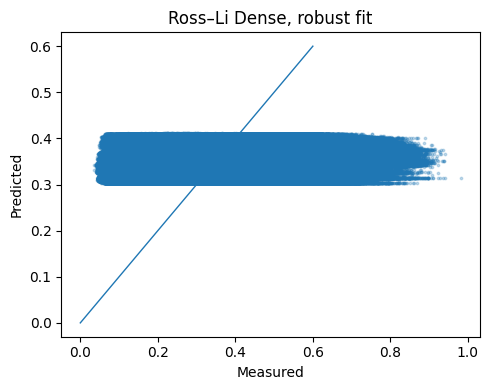

In [29]:
import numpy as np, polars as pl, matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

# ── pull data (band5, plot_10) ───────────────────────────────────────
g = df.filter((pl.col("plot_id")=="plot_10") &
              (pl.col("band5").is_finite())   &
              (pl.col("band5")>0) & (pl.col("band5")<1))

sza  = g["sza_deg"].to_numpy()
vza  = g["vza_deg_new"].to_numpy()
raa  = g["raa_deg"].to_numpy()
R    = g["band5"].to_numpy()

# ── Li-Dense geometric kernel  ---------------------------------------
def li_dense(s, v, f):
    """Li-Dense geometric kernel (Wanner & Li 1995)"""
    # canopy parameters for dense crowns
    h_b = 2.0           # crown-to-trunk height ratio
    b   = 1.0 / np.sqrt(1 + h_b**2)

    tan_s, tan_v = np.tan(s), np.tan(v)
    cos_f        = np.cos(f)
    D            = np.sqrt(tan_s**2 + tan_v**2 - 2*tan_s*tan_v*cos_f)
    # avoid 0 division
    cos_x = h_b * np.sqrt(D**2 + (tan_s*tan_v*np.sin(f))**2) / (cos_s:=np.cos(s)*np.cos(v))
    cos_x = np.clip(cos_x, -1, 1)
    x     = np.arccos(cos_x)

    return ((1/np.pi)*(x - np.sin(x)*np.cos(x)) *
            (cos_s:=np.cos(s)+np.cos(v))/(np.cos(s)*np.cos(v))) - (1/b) + b

# ── Ross volume kernel (Ross-Thick) -----------------------------------
def ross_vol(s, v, f):
    return ((np.pi/2 - s) + (np.pi/2 - v) -
            np.sqrt(np.cos(s)**2 + np.cos(v)**2 -
                    2*np.cos(s)*np.cos(v)*np.cos(f)))

# ── full Ross–Li (dense) model ---------------------------------------
def ross_li_dense(ang, f_iso, f_vol, f_geo):
    s,v,f = map(np.radians, ang)
    return (f_iso +
            f_vol * ross_vol(s,v,f) +
            f_geo * li_dense(s,v,f))

# ── robust fit (soft-L1) ---------------------------------------------
loss_scale = 0.03                     # expected noise ~3 %
res = least_squares(
        lambda p, *_: ross_li_dense((sza,vza,raa), *p) - R,
        x0=[np.median(R), 0.05, 0.05],
        bounds=([0,0,0], [1,1,1]),
        loss="soft_l1", f_scale=loss_scale, max_nfev=40000)

f_iso, f_vol, f_geo = res.x
print(f"f_iso={f_iso:.3f},  f_vol={f_vol:.3f},  f_geo={f_geo:.3f}")

# ── diagnostics -------------------------------------------------------
R_hat = ross_li_dense((sza,vza,raa), *res.x)
rmse  = np.sqrt(mean_squared_error(R, R_hat))
print(f"RMSE={rmse:.4f},   nRMSE={(rmse/R.mean())*100:.1f}%")

plt.figure(figsize=(5,4))
plt.scatter(R, R_hat, s=3, alpha=0.25)
plt.plot([0,0.6],[0,0.6], lw=1); plt.xlabel("Measured"); plt.ylabel("Predicted")
plt.title("Ross–Li Dense, robust fit"); plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'VZA distribution')

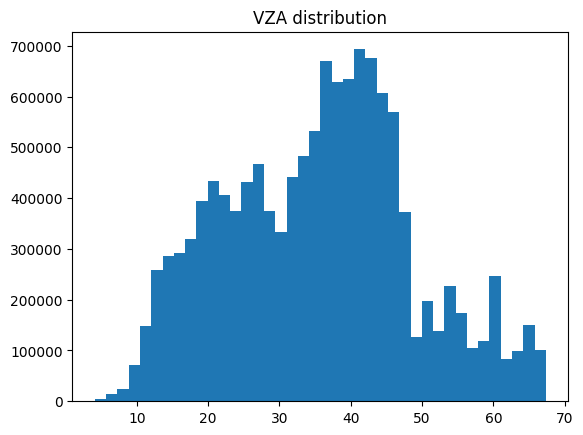

In [23]:
plt.hist(vza, bins=40); plt.title("VZA distribution")

min / max : 0.03534103184938431 0.9821608662605286


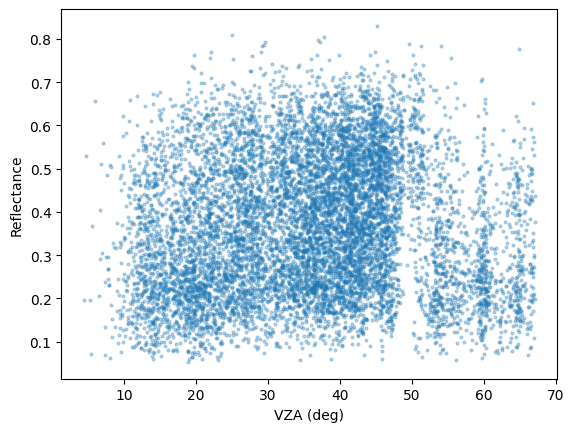

In [26]:
# 1. Is reflectance well-scaled?
print("min / max :", df[band].min(), df[band].max())

# 2. Do we see any BRDF slope?
plt.scatter(df_fit["vza_deg_new"], df_fit[band], s=4, alpha=0.3)
plt.xlabel("VZA (deg)"); plt.ylabel("Reflectance"); plt.show()



ρ₀,k,θ: [4.06834254e-01 1.16326017e-01 1.75561447e-17]


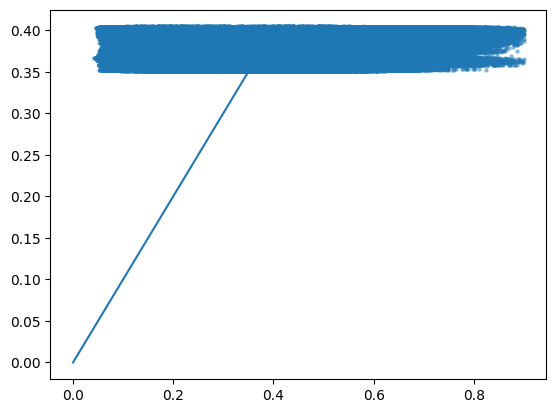

In [30]:
from scipy.optimize import curve_fit

# 3. Hard-trim obvious junk and refit
df_fit = df_fit.filter(
    (pl.col(band).is_finite()) &
    (pl.col(band) > 0.01) &          # drop ultrasmall noise
    (pl.col(band) < 0.9)            # drop clouds / glare
)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[np.median(R), 1.0, 0.1], bounds=(0, [1, 5, 1]))
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);
plt.show()


ρ₀,k,θ: [0.24876008 0.00581559 0.00582152]


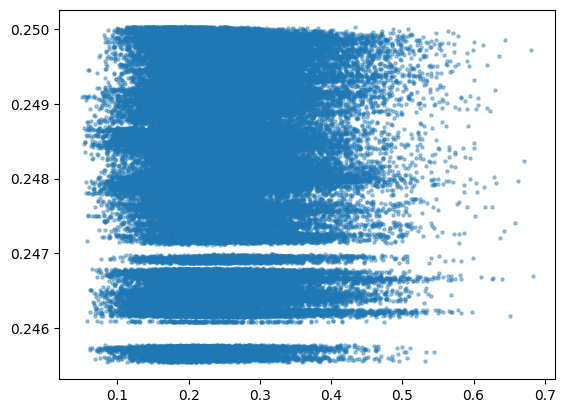

In [39]:
ndvi = (df["band5"] - df["band3"]) / (df["band5"] + df["band3"])
df = df.with_columns(ndvi.alias("ndvi"))
df_fit = df.filter((pl.col("ndvi") > 0.9) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[np.median(R), 1.0, 0.1], bounds=(0, [1, 5, 1]))
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);  plt.show()

Text(0, 0.5, '⟨R⟩')

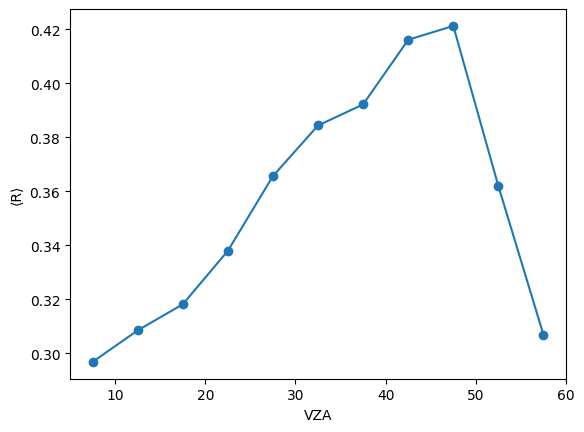

In [27]:
# bin by VZA
bins  = np.arange(5, 65, 5)
digit = np.digitize(vza, bins)
R_mean = [R[digit==i].mean() for i in range(1, len(bins))]
plt.plot(bins[:-1]+2.5, R_mean, 'o-'); plt.xlabel("VZA"); plt.ylabel("⟨R⟩")


C:\Users\dadoi\AppData\Local\Temp\ipykernel_12780\1588378869.py:11: RuntimeWarning: Mean of empty slice.
  mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
C:\Users\dadoi\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\dadoi\AppData\Local\Temp\ipykernel_12780\1588378869.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(); plt.show()
C:\Users\dadoi\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


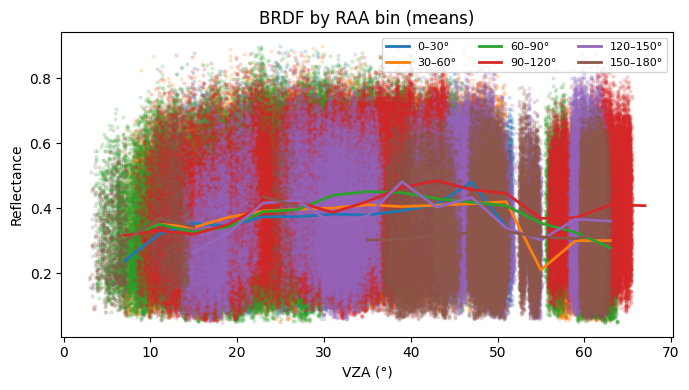

In [33]:
bins = np.arange(0, 181, 30)
col  = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]

plt.figure(figsize=(7,4))
for i in range(len(bins)-1):
    sel = (raa>=bins[i]) & (raa<bins[i+1])
    # scatter cloud, but no label -> omitted from legend
    plt.scatter(vza[sel], R[sel], s=4, alpha=0.15, c=col[i])
    # robust central tendency per 4° VZA bin
    vza_bin = np.arange(5, 66, 4)
    mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
    plt.plot(vza_bin+2, mean_R, c=col[i], lw=2, label=f"{bins[i]}–{bins[i+1]}°")

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF by RAA bin (means)")
plt.legend(fontsize=8, ncol=3)
plt.tight_layout(); plt.show()


C:\Users\dadoi\AppData\Local\Temp\ipykernel_12780\3532487275.py:12: RuntimeWarning: Mean of empty slice.
  meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]


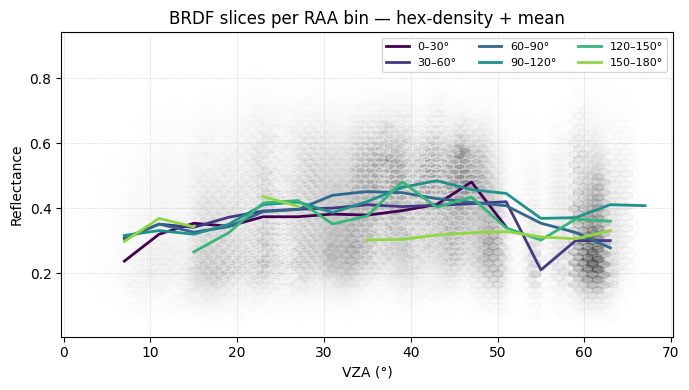

In [34]:
bins     = np.arange(0, 181, 30)
base_cmap = plt.get_cmap("viridis")
colors   = [base_cmap(i/6) for i in range(6)]
vza_bin  = np.arange(5, 66, 4)

plt.figure(figsize=(7,4))
for i,(lo,hi) in enumerate(zip(bins[:-1], bins[1:])):
    sel = (raa>=lo) & (raa<hi)
    plt.hexbin(vza[sel], R[sel], gridsize=45,
               cmap=plt.get_cmap("Greys"),
               alpha=0.25, mincnt=4)
    meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]
    plt.plot(vza_bin+2, meanR, c=colors[i], lw=2,
             label=f"{lo}–{hi}°")

plt.xlabel("VZA (°)");  plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — hex-density + mean")
plt.grid(ls=":", lw=0.4);  plt.legend(ncol=3, fontsize=8)
plt.tight_layout();  plt.show()

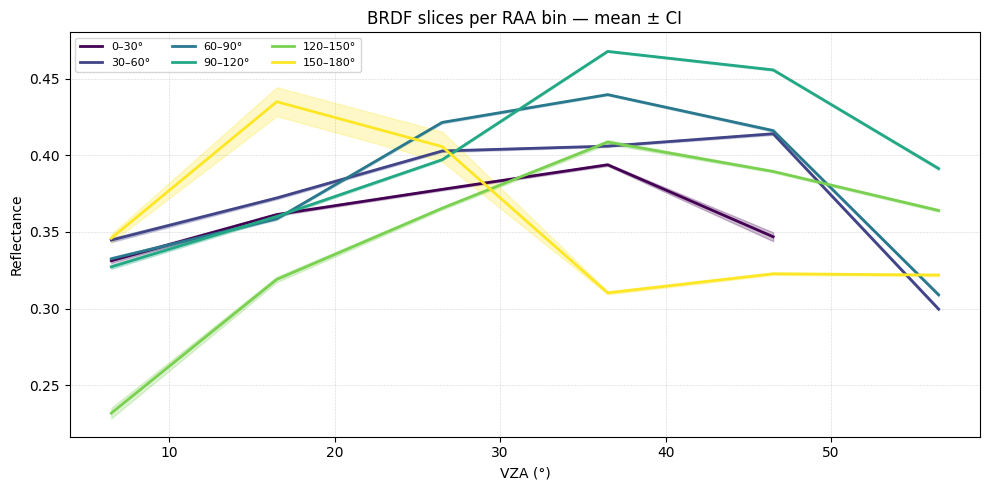

In [35]:
import numpy as np, matplotlib.pyplot as plt

# parameters
bins_raa   = np.arange(0, 181, 30)
bins_vza   = np.arange(5, 66, 10)                 # 3° rolling step
colors     = plt.get_cmap("viridis")(np.linspace(0, 1, len(bins_raa)-1))

plt.figure(figsize=(10, 5))
for i, (lo, hi) in enumerate(zip(bins_raa[:-1], bins_raa[1:])):
    sel = (raa >= lo) & (raa < hi)
    idx = np.digitize(vza[sel], bins_vza) - 1     # map each VZA to a bin
    means, sigmas, counts = [], [], []
    for b in range(len(bins_vza)-1):
        r = R[sel][idx == b]
        if r.size:                                # skip empty bins
            means.append(r.mean())
            sigmas.append(r.std() / np.sqrt(r.size))
            counts.append(bins_vza[b] + 1.5)      # bin centre
    plt.plot(counts, means, c=colors[i], lw=2, label=f"{lo}–{hi}°")
    plt.fill_between(counts, np.array(means)-sigmas, np.array(means)+sigmas,
                     color=colors[i], alpha=0.25)

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — mean ± CI"); plt.grid(ls=":", lw=0.4)
plt.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()


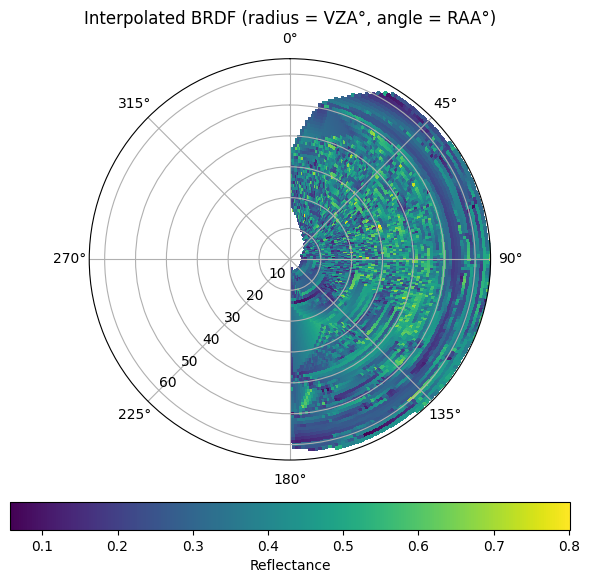

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# assume arrays raa (deg 0‑180), vza (deg 0‑65), R (reflectance) already exist
# substitute with your existing arrays when integrating

# --- 1. build regular grid ---------------------------------------------------
theta = np.linspace(0, np.pi, 181)          # 0‑180° → radians for polar
radius = np.linspace(0, 65, 66)             # VZA grid (deg)
T, R_grid = np.meshgrid(theta, radius)

# --- 2. interpolate reflectance onto grid ------------------------------------
points = np.column_stack((np.radians(raa), vza))   # original polar coords
values = R
Z = griddata(points, values, (T, R_grid), method='linear')

# mask empty cells for clarity
Z_masked = np.ma.masked_invalid(Z)

# --- 3. polar plot ------------------------------------------------------------
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
pcm = ax.pcolormesh(T, R_grid, Z_masked, shading='nearest', cmap='viridis')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)      # 0° = north, clockwise
ax.set_rlim(0, 65); ax.set_rlabel_position(225)
ax.set_title("Interpolated BRDF (radius = VZA°, angle = RAA°)")
cbar = plt.colorbar(pcm, orientation='horizontal', pad=0.08)
cbar.set_label("Reflectance")
plt.tight_layout()
plt.show()
